In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import h5py
path = '/z/omarioni/gradients/_simulations/snap_127/'
snap = h5py.File(path + 'subhalo_000.h5py', 'r')
def printname(name):
    print (name)
snap.visit(printname)

Center
Drk
Drk/Coordinates
Drk/IDs
Drk/Masses
Drk/Potential
Drk/Velocities
Gas
Gas/Coordinates
Gas/IDs
Gas/Masses
Gas/Metallicity
Gas/Potential
Gas/Total_Metallicity
Gas/Velocities
M200
Omega_0
Omega_Baryon
Omega_Lambda
R200
Redshift
Str
Str/Birth_Density
Str/Birth_Position
Str/Birth_Velocities
Str/Coordinates
Str/FormationTime
Str/IDs
Str/Masses
Str/Metallicity
Str/Potential
Str/Total_Metallicity
Str/Velocities
SubHalfmassRad
SubhaloMass
Time
h


#### We check the cosmological parameters

In [2]:
snap = h5py.File(path + 'subhalo_000.h5py', 'r')
h    = snap['/h'][()]
Om_L = snap['/Omega_Lambda'][()]
Om_M = snap['/Omega_0'][()]

print ('h = ',h)
print ('Omega Lambda = ', Om_L)
print ('Omega Matter = ', Om_M)

h =  0.6777
Omega Lambda =  0.682
Omega Matter =  0.318


#### We read the subhalos with no low-mass particles

In [2]:
import numpy as np
subh = np.loadtxt('../_data/subhalos.dat')

halo_mask, = np.where((subh[:,15]==0) & (subh[:,16]==0))

subh_name = subh[:,0][halo_mask]
subh_ind  = np.int_(subh_name)
# nsubh = len(subh_name)

print(subh_ind)

[ 0  1  3  4  5  6  7  9 20 21 22 27 28 31 33 35 36 37 38 39 41 42 45 46
 49 50 51 53 54 64 65 66 69 73 74 79 84 85 87 88 90 91 92 95 96]


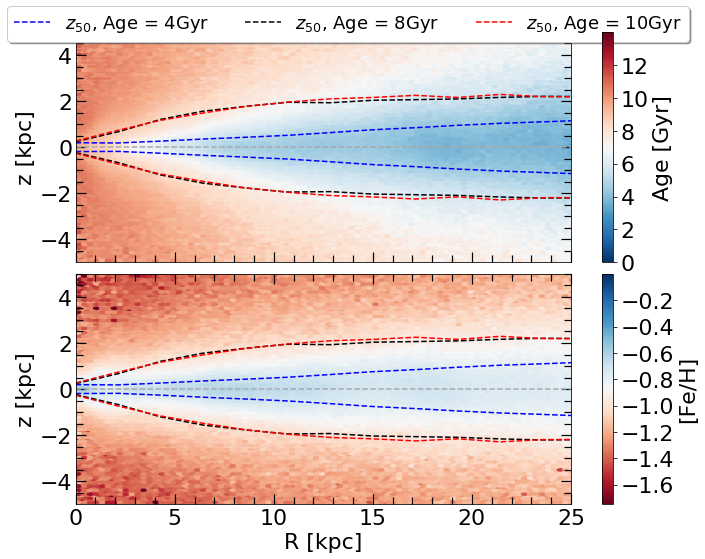

In [35]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in subh_ind[:1]:
    
    snap = h5py.File(path + 'subhalo_'+str('%03d'%j)+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    met  = snap['/Str/Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    age_ = time.conv2(sft, h, Om_L, Om_M)
    aa   = ~np.isnan(age_)
    age_ = age_[aa]
    age  = np.nanmax(age_) - age_
    
    FeH_ = met[:,8]/met[:,0]
    FeH  = FeH_/0.0127

    xstr = pstr[:,0]*aexp/h
    ystr = pstr[:,1]*aexp/h
    zstr = pstr[:,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[:,0] *np.sqrt(aexp)
    v_y = vstr[:,1] *np.sqrt(aexp)
    v_z = vstr[:,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr/h

    veloc,=np.where(rstr < 3)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,5)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr

    Rstr = np.sqrt(xn_str**2 + yn_str**2)
    
    Rstr   = Rstr[aa]
    zn_str = zn_str[aa]
    mstr   = mstr[aa]
    FeH    = FeH[aa]
    
    mask,  = np.where((Rstr <= 30) & (zn_str <= 5) & (zn_str >-5))
    # mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))

    nbin = 15
    # med_R,nodo_R = bines.rbin1(Rstr[mask],nbin)
    nodo_R = np.linspace(0,30,nbin)
    med_R  = nodo_R

    age_4,  = np.where((age[mask] > 3.5) & (age[mask] < 4.5))
    age_8,  = np.where((age[mask] > 7.5) & (age[mask] < 8.5))
    age_10, = np.where((age[mask] > 9.5) & (age[mask] < 10.5))

    kk,  = np.where(FeH[mask]>0)
    Fe_H = np.log10(FeH[mask][kk])
    
    rr   = Rstr[mask]
    rr4  = rr[age_4]
    rr8  = rr[age_8]
    rr10 = rr[age_10]

    zz  = zn_str[mask]
    z4  = zz[age_4]
    z8  = zz[age_8]
    z10 = zz[age_10]

    mass = mstr[mask]
    M4  = mass[age_4]
    M8  = mass[age_8]
    M10 = mass[age_10]

    z4a  = np.zeros(nbin)
    z8a  = np.zeros(nbin)
    z10a = np.zeros(nbin)

    for i in range(0,nbin-1):
        zetas4,  = np.where((rr4  >= nodo_R[i]) & (rr4  < nodo_R[i+1]) & (z4 > 0))
        zetas8,  = np.where((rr8  >= nodo_R[i]) & (rr8  < nodo_R[i+1]) & (z8 > 0))
        zetas10, = np.where((rr10 >= nodo_R[i]) & (rr10 < nodo_R[i+1]) & (z10 > 0))

        zz4  = np.argsort(z4[zetas4])
        zz8  = np.argsort(z8[zetas8])
        zz10 = np.argsort(z10[zetas10])

        Mbin_4  = np.cumsum(M4[zetas4][zz4])
        Mbin_8  = np.cumsum(M8[zetas8][zz8])
        Mbin_10 = np.cumsum(M10[zetas10][zz10])

        kk4,  = np.where(Mbin_4  < Mbin_4[-1]/2)
        kk8,  = np.where(Mbin_8  < Mbin_8[-1]/2)
        kk10, = np.where(Mbin_10 < Mbin_10[-1]/2)

        zeta4  = z4[zetas4][zz4]
        zeta8  = z8[zetas8][zz8]
        zeta10 = z10[zetas10][zz10]

        z4a[i]  = zeta4[kk4][-1]
        z8a[i]  = zeta8[kk8][-1]
        z10a[i] = zeta10[kk10][-1]


    fig0, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
    fig0.subplots_adjust(bottom=0.10, left =0.10, right = 0.96, top = 0.92,hspace=0.05)
    
    hb0 =ax[1].hexbin(rr[kk],zz[kk],Fe_H,cmap='RdBu',vmin=-1.75,vmax=0)
    cbar0 = fig0.colorbar(hb0,ax=ax[1])
    cbar0.set_label('[Fe/H]',fontsize=22)
    cbar0.ax.tick_params(labelsize=22)
    cbar0.set_ticks([-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2])
    ax[1].plot(med_R,z4a, ls='--',color='b', label='$z_{50}$, Age = 4Gyr')
    ax[1].plot(med_R,z8a, ls='--',color='k', label='$z_{50}$, Age = 8Gyr')
    ax[1].plot(med_R,z10a,ls='--',color='r', label='$z_{50}$, Age = 10Gyr')
    ax[1].axhline(y=0,ls='--',color='darkgray')
    ax[1].plot(med_R,-z4a,ls='--',color='b')
    ax[1].plot(med_R,-z8a,ls='--',color='k')
    ax[1].plot(med_R,-z10a,ls='--',color='r')
    ax[1].set_ylim(-5,5)
    ax[1].set_xlim(0,25)
#     ax[0].set_xticklabels([])
#     ax[0].set_xlabel('R [kpc]',fontsize=20)
    ax[1].minorticks_on()
    ax[1].tick_params( labelsize=22)
    ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right='on',top='on')
    ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right='on',top='on')
#     ax[0,0].set_xlabel('R [kpc]',fontsize=15)
    ax[1].set_ylabel('z [kpc]',fontsize=22)
    ax[1].set_xlabel('R [kpc]',fontsize=22)
    
    

#     fig0.savefig('../_imagenes/metallicity/Rz_met_s'+str('%03d'%j)+'.png',dpi=75, xxbox_inches='tight')
    
    
#     fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
#     fig1.subplots_adjust(bottom=0.10, left =0.08, right = 0.98, top = 0.95,hspace=0.05)
    hb1 =ax[0].hexbin(rr,zz,age[mask],cmap='RdBu_r',vmin=0,vmax=14)
    cbar1 = fig0.colorbar(hb1,ax=ax[0])
    cbar1.set_label('Age [Gyr]',fontsize=22)
    cbar1.ax.tick_params( labelsize=22)
    cbar1.set_ticks([0,2,4,6,8,10,12])
    ax[0].plot(med_R,z4a,ls='--',color='b', label='$z_{50}$, Age = 4Gyr')
    ax[0].plot(med_R,z8a,ls='--',color='k', label='$z_{50}$, Age = 8Gyr')
    ax[0].plot(med_R,z10a,ls='--',color='r', label='$z_{50}$, Age = 10Gyr')
    ax[0].axhline(y=0,ls='--',color='darkgray')
    ax[0].plot(med_R,-z4a,ls='--',color='b')
    ax[0].plot(med_R,-z8a,ls='--',color='k')
    ax[0].plot(med_R,-z10a,ls='--',color='r')
    ax[0].set_ylim(-5,5)
    ax[0].set_xlim(0,25)
    ax[0].minorticks_on()
    ax[0].tick_params( labelsize=22)
    ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right='on',top='on')
    ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right='on',top='on')
    ax[0].set_ylabel('z [kpc]',fontsize=22)
    ax[0].legend(fontsize=18,loc='upper center', bbox_to_anchor=(0.55, 1.15),
                 ncol=3, fancybox=True, shadow=True)
        
#     ax[1].legend(fontsize=15,loc='upper center', bbox_to_anchor=(0.5, 1.05),
#                  ncol=3, fancybox=True, shadow=True)
#     fig1.savefig('../_imagenes/ages/Rz_ages_s'+str('%03d'%j)+'.png',dpi=75, xxbox_inches='tight')
    fig0.savefig('../_imagenes/metallicity/Rz_met_s'+str('%03d'%j)+'.pdf',dpi=75, xxbox_inches='tight')
    

### Plot 6 Navarro_etal2018

In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in subh_ind[:1]:
    
    snap = h5py.File(path + 'subhalo_'+str('%03d'%j)+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    met  = snap['/Str/Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    age_ = time.conv2(sft, h, Om_L, Om_M)
    aa   = ~np.isnan(age_)
    age_ = age_[aa]
    age  = np.nanmax(age_) - age_
    
    FeH_ = met[:,8]/met[:,0]
    FeH  = FeH_/0.0127

    xstr = pstr[:,0]*aexp/h
    ystr = pstr[:,1]*aexp/h
    zstr = pstr[:,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[:,0] *np.sqrt(aexp)
    v_y = vstr[:,1] *np.sqrt(aexp)
    v_z = vstr[:,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr/h

    veloc,=np.where(rstr < 3)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,5)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr

    Rstr = np.sqrt(xn_str**2 + yn_str**2)
    
    Rstr   = Rstr[aa]
    zn_str = zn_str[aa]
    mstr   = mstr[aa]
    FeH    = FeH[aa]
    
    mask,  = np.where((Rstr <= 30) & (zn_str <= 5) & (zn_str >-5))
    # mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))

    nbin = 15
    # med_R,nodo_R = bines.rbin1(Rstr[mask],nbin)
    nodo_R = np.linspace(0,30,nbin)
    med_R  = nodo_R

    kk,  = np.where(FeH[mask]>0)
    Fe_H = np.log10(FeH[mask][kk])
    
    rr   = Rstr[mask]
    zz   = zn_str[mask]
    mass = mstr[mask]

    z50  = np.zeros(nbin)

    for i in range(0,nbin-1):
        zetas, = np.where((rr  >= nodo_R[i]) & (rr  < nodo_R[i+1])  & (zz > 0))

        z_sort = np.argsort(zz[zetas])

        Mbin = np.cumsum(mass[zetas][z_sort])

        limit, = np.where(Mbin  < Mbin[-1]/2)

        z50[i]  = zz[zetas][z_sort][limit][-1]


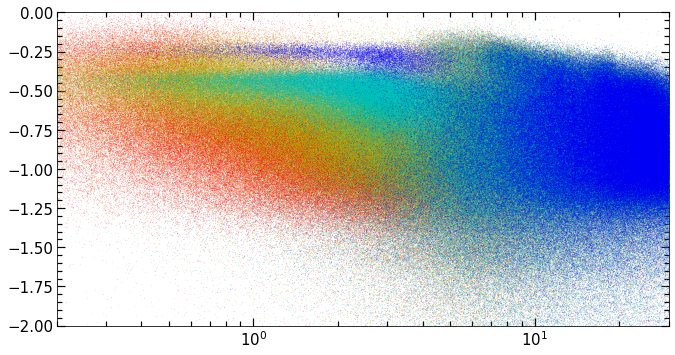

In [12]:
age_cut1, = np.where((age[kk]>3.5) & (age[kk]<4.5))
age_cut2, = np.where((age[kk]>5.5) & (age[kk]<6.5))
age_cut3, = np.where((age[kk]>7.5) & (age[kk]<8.5))
age_cut4, = np.where((age[kk]>9.5) & (age[kk]<10.5))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)
# hb =ax.hexbin(rr[kk],zz[kk],Fe_H,cmap='RdBu',vmin=-1.75,vmax=0)
# cbar = fig.colorbar(hb)
# cbar.set_label('[Fe/H]',fontsize=15)
ax.plot(rr[kk][age_cut1],Fe_H[age_cut1],'.b',markersize=0.1,zorder=4)#c=age[kk][age_cut])
ax.plot(rr[kk][age_cut2],Fe_H[age_cut2],'.c',markersize=0.1,zorder=3)#c=age[kk][age_cut])
ax.plot(rr[kk][age_cut3],Fe_H[age_cut3],'.y',markersize=0.1,zorder=2)#c=age[kk][age_cut])
ax.plot(rr[kk][age_cut4],Fe_H[age_cut4],'.r',markersize=0.1,zorder=1)#c=age[kk][age_cut])
ax.set_ylim(-2,0)
ax.set_xlim(0.2,30)
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
# ax.set_xlabel('R [kpc]',fontsize=15)
# ax.set_ylabel('z [kpc]',fontsize=15)
# fig.savefig('../_imagenes/metallicity/Rz_met_s'+str('%03d'%j)+'.png',dpi=75, xxbox_inches='tight')

(-5, 0)

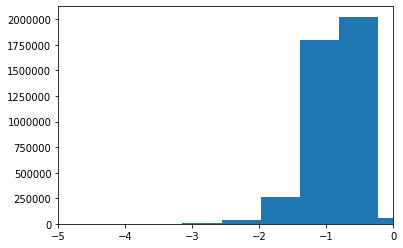

In [11]:
plt.hist(Fe_H,bins=60)
plt.xlim(-5,0)

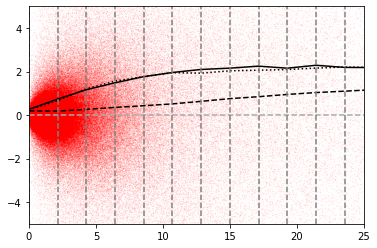

In [73]:
import matplotlib.pyplot as plt
# mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))
# plt.plot(Rstr[mask],zn_str[mask], '.k',markersize=0.05,alpha =0.7)
# plt.plot(rr4,z4, '.b',markersize=0.05,alpha=0.7)
# plt.plot(rr8,z8, '.g',markersize=0.05, alpha= 0.7)
plt.plot(rr10,z10, '.r',markersize=0.05, alpha= 0.7)
plt.plot(med_R,z4a,ls='--',color='k')
plt.plot(med_R,z8a,ls=':',color='k')
plt.plot(med_R,z10a,ls='-',color='k')
plt.axhline(y=0,ls='--',color='darkgray')
for i in range(len(med_R)):
    plt.axvline(x=med_R[i],ls='--',color='gray')
plt.ylim(-5,5)
plt.xlim(0,25)
plt.show()

In [168]:
print (z10a)

[0.59001565 0.37430674 0.08027193 0.61642742 0.85036403 0.60880661
 0.02165842 0.07126015 0.49309099 2.08326912 1.82632685 1.10449982
 0.63304985 0.47773719 0.        ]


In [59]:
import numpy as np
kk,=np.where(FeH[mask]>0)
print(len(FeH[mask]))
print(len(FeH[mask])-len(kk))
Fe_H = np.log10(FeH[mask][kk]/0.0127)

4192273
66


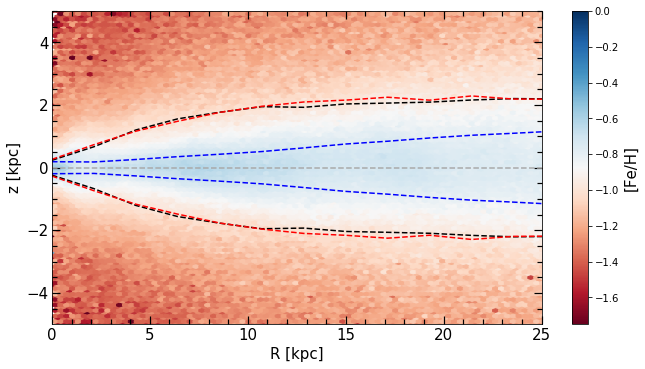

In [63]:
import matplotlib.pyplot as plt
import numpy as np
# mask2, = np.where((Rstr < 50) & (zn_str < 5) & (zn_str > -5))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)
hb =ax.hexbin(Rstr[mask][kk],zn_str[mask][kk],Fe_H,cmap='RdBu',vmin=-1.75,vmax=0)
cbar = fig.colorbar(hb)
cbar.set_label('[Fe/H]',fontsize=15)
ax.plot(med_R,z4a,ls='--',color='b')
ax.plot(med_R,z8a,ls='--',color='k')
ax.plot(med_R,z10a,ls='--',color='r')
ax.axhline(y=0,ls='--',color='darkgray')
ax.plot(med_R,-z4a,ls='--',color='b')
ax.plot(med_R,-z8a,ls='--',color='k')
ax.plot(med_R,-z10a,ls='--',color='r')
ax.set_ylim(-5,5)
ax.set_xlim(0,25)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel('z [kpc]',fontsize=15)
plt.show()
fig.savefig('../_imagenes/Rz_met.png',dpi=75, xxbox_inches='tight')


In [89]:
Fe_H.max()

-3.433891

(-5, 0)

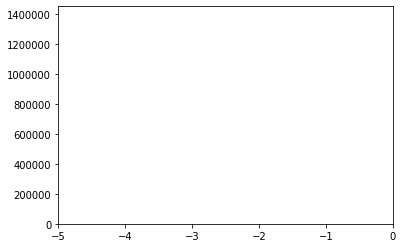

In [58]:
plt.hist(Fe_H,bins=60)
plt.xlim(-5,-0)

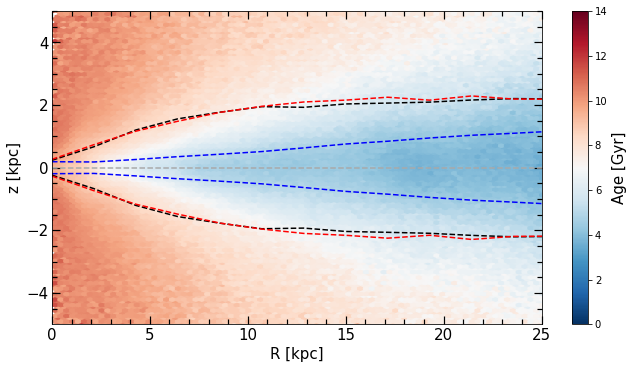

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)
hb =ax.hexbin(Rstr[mask],zn_str[mask],age[mask],cmap='RdBu_r',vmin=0,vmax=14)
cbar = fig.colorbar(hb)
cbar.set_label('Age [Gyr]',fontsize=15)
ax.plot(med_R,z4a,ls='--',color='b')
ax.plot(med_R,z8a,ls='--',color='k')
ax.plot(med_R,z10a,ls='--',color='r')
ax.axhline(y=0,ls='--',color='darkgray')
ax.plot(med_R,-z4a,ls='--',color='b')
ax.plot(med_R,-z8a,ls='--',color='k')
ax.plot(med_R,-z10a,ls='--',color='r')
ax.set_ylim(-5,5)
ax.set_xlim(0,25)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylabel('z [kpc]',fontsize=15)

plt.show()
fig.savefig('../_imagenes/Rz_ages.png',dpi=75, xxbox_inches='tight')

In [83]:
a = np.array([1,2,np.nan,4])
print(a)

[ 1.  2. nan  4.]


In [91]:
print (len(age[~np.isnan(age)]))
print (len(age))

5720155
5773121


(array([ 47219.,  47647.,  51484.,  46189.,  51435.,  48631.,  52606.,
         56018.,  56757.,  59190.,  63689.,  68241.,  76687.,  75247.,
         80915.,  89326.,  90706.,  90078.,  99732., 113594., 115337.,
        129871., 134658., 135842., 154984., 157042., 161281., 168296.,
        161167., 154091., 148901., 140691., 134014., 163802., 161395.,
        135992., 147075., 143836., 145178., 135676., 140648., 127047.,
        105475.,  88884.,  70724., 119045., 162474., 131603.,  71696.,
         67473.,  65643.,  50163.,  76311.,  47499.,  37154.,  30128.,
         19395.,   9396.,   4431.,    446.]),
 array([ 0.        ,  0.22535676,  0.45071352,  0.6760703 ,  0.90142703,
         1.1267837 ,  1.3521405 ,  1.5774972 ,  1.8028541 ,  2.0282109 ,
         2.2535675 ,  2.4789243 ,  2.704281  ,  2.929638  ,  3.1549945 ,
         3.3803513 ,  3.6057081 ,  3.8310647 ,  4.0564218 ,  4.2817783 ,
         4.507135  ,  4.732492  ,  4.9578485 ,  5.183205  ,  5.408562  ,
         5.633919  , 

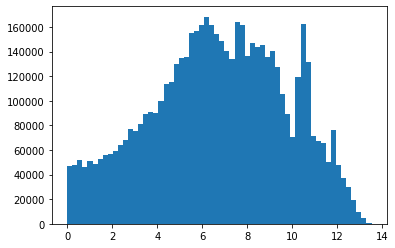

In [45]:
plt.hist(age,bins=60)

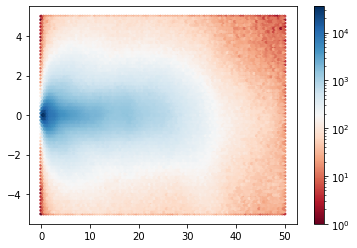

In [61]:
import matplotlib.pyplot as plt
plt.hexbin(Rstr[mask],zn_str[mask],cmap='RdBu',bins='log')
plt.colorbar()

In [10]:
plt.close()

(array([100926., 378722., 678139., 839371., 884780., 956852., 729033.,
        502959., 356501., 292605.]),
 array([ 0.16308884,  1.5152293 ,  2.86737   ,  4.2195106 ,  5.571651  ,
         6.9237914 ,  8.275932  ,  9.628073  , 10.980213  , 12.332354  ,
        13.684494  ], dtype=float32),
 <a list of 10 Patch objects>)

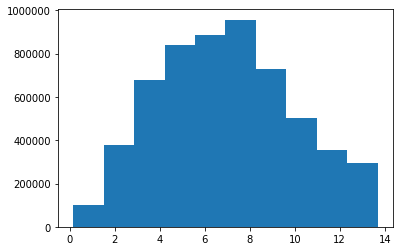

In [16]:
plt.hist(age)

In [79]:
nodo_R = np.linspace(0,25,20)
med_R = nodo_R[:19]


In [81]:
print(nodo_R)

[ 0.          1.31578947  2.63157895  3.94736842  5.26315789  6.57894737
  7.89473684  9.21052632 10.52631579 11.84210526 13.15789474 14.47368421
 15.78947368 17.10526316 18.42105263 19.73684211 21.05263158 22.36842105
 23.68421053 25.        ]


In [82]:
print(med_R)

[ 0.          1.31578947  2.63157895  3.94736842  5.26315789  6.57894737
  7.89473684  9.21052632 10.52631579 11.84210526 13.15789474 14.47368421
 15.78947368 17.10526316 18.42105263 19.73684211 21.05263158 22.36842105
 23.68421053]


(array([4.810000e+02, 2.812480e+05, 2.666375e+06, 2.265903e+06,
        4.783120e+05, 6.193700e+04, 1.213300e+04, 4.625000e+03,
        1.483000e+03, 3.570000e+02]),
 array([1.3971096e-07, 8.3924590e-07, 1.5387809e-06, 2.2383158e-06,
        2.9378507e-06, 3.6373858e-06, 4.3369205e-06, 5.0364556e-06,
        5.7359907e-06, 6.4355254e-06, 7.1350605e-06], dtype=float32),
 <a list of 10 Patch objects>)

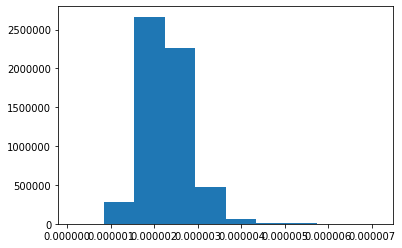

In [140]:
plt.hist(mstr)

In [2]:
# import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines

path = '/z/omarioni/gradients/_simulations/snap_127/'

subh = (0,1,3,4,5)

# for j in range(0,1):
j= 0
snap = h5py.File(path + 'subhalo_'+str('%03d'%subh[j])+'.h5py', 'r')

aexp = snap['/Time'][()]
h    = snap['/h'][()]
Om_L = snap['/Omega_Lambda'][()]
Om_M = snap['/Omega_0'][()]

pstr = snap['/Str/Coordinates'][()]
mstr = snap['/Str/Masses'][()]
vstr = snap['/Str/Velocities'][()]

met  = snap['/Str/Metallicity'][()]
sft  = snap['/Str/FormationTime'][()]

FeH = met[:,8]/met[:,0]
age = time.conv2(sft, h, Om_L, Om_M)

xstr = pstr[:,0]*aexp/h
ystr = pstr[:,1]*aexp/h
zstr = pstr[:,2]*aexp/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

v_x = vstr[:,0] *np.sqrt(aexp)
v_y = vstr[:,1] *np.sqrt(aexp)
v_z = vstr[:,2] *np.sqrt(aexp)

#----------------------masas----------------------------
mstr = mstr/h

veloc,=np.where(rstr < 3)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,5)

xn_str = e1x*xstr + e1y*ystr + e1z*zstr
yn_str = e2x*xstr + e2y*ystr + e2z*zstr
zn_str = e3x*xstr + e3y*ystr + e3z*zstr

Rstr = np.sqrt(xn_str**2 + yn_str**2)

mask, = np.where((Rstr <= 50) & (zn_str <= 5) & (zn_str >-5))
# mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))

nbin = 15
# med_R,nodo_R = bines.rbin1(Rstr[mask],nbin)
nodo_R = np.linspace(0,50,nbin)
med_R = nodo_R

age_1,  = np.where((age[mask] > 0.5) & (age[mask] < 1.5))
age_2,  = np.where((age[mask] > 1.5) & (age[mask] < 2.5))
age_3,  = np.where((age[mask] > 2.5) & (age[mask] < 3.5))
age_4,  = np.where((age[mask] > 3.5) & (age[mask] < 4.5))
age_5,  = np.where((age[mask] > 4.5) & (age[mask] < 5.5))
age_6,  = np.where((age[mask] > 5.5) & (age[mask] < 6.5))
age_7,  = np.where((age[mask] > 6.5) & (age[mask] < 7.5))
age_8,  = np.where((age[mask] > 7.5) & (age[mask] < 8.5))
age_9,  = np.where((age[mask] > 8.5) & (age[mask] < 9.5))
age_10,  = np.where((age[mask] > 9.5) & (age[mask] < 10.5))
age_11, = np.where((age[mask] > 10.5) & (age[mask] < 11.5))
age_12, = np.where((age[mask] > 11.5) & (age[mask] < 12.5))
age_13, = np.where((age[mask] > 12.5) & (age[mask] < 13.5))

rr = Rstr[mask]
rr1 = rr[age_1]
rr2 = rr[age_2]
rr3 = rr[age_3]
rr4 = rr[age_4]
rr5 = rr[age_5]
rr6 = rr[age_6]
rr7 = rr[age_7]
rr8 = rr[age_8]
rr9 = rr[age_9]
rr10 = rr[age_10]
rr11 = rr[age_11]
rr12 = rr[age_12]
rr13 = rr[age_13]

zz = zn_str[mask]
z1  = zz[age_1]
z2  = zz[age_2]
z3  = zz[age_3]
z4  = zz[age_4]
z5  = zz[age_5]
z6  = zz[age_6]
z7  = zz[age_7]
z8  = zz[age_8]
z9  = zz[age_9]
z10 = zz[age_10]
z11 = zz[age_11]
z12 = zz[age_12]
z13 = zz[age_13]

mass = mstr[mask]
M1 = mass[age_1]
M2 = mass[age_2]
M3 = mass[age_3]
M4 = mass[age_4]
M5 = mass[age_5]
M6 = mass[age_6]
M7 = mass[age_7]
M8 = mass[age_8]
M9 = mass[age_9]
M10 = mass[age_10]
M11 = mass[age_11]
M12 = mass[age_12]
M13 = mass[age_13]


z4a  = np.zeros(nbin)
z8a  = np.zeros(nbin)
z10a = np.zeros(nbin)

for i in range(0,nbin-1):
    zetas4,  = np.where((rr4 >= nodo_R[i])  & (rr4 < nodo_R[i+1])  & (z4 > 0))
    zetas8,  = np.where((rr8 >= nodo_R[i])  & (rr8 < nodo_R[i+1])  & (z8 > 0))
    zetas10, = np.where((rr10 >= nodo_R[i]) & (rr10 < nodo_R[i+1]) & (z10 > 0))

    zz4  = np.argsort(z4[zetas4])
    zz8  = np.argsort(z8[zetas8])
    zz10 = np.argsort(z10[zetas10])
    
    Mbin_4  = np.cumsum(M4[zetas4][zz4])
    Mbin_8  = np.cumsum(M8[zetas8][zz8])
    Mbin_10 = np.cumsum(M10[zetas10][zz10])
    
    kk4,  = np.where(Mbin_4  < Mbin_4[-1]/2)
    kk8,  = np.where(Mbin_8  < Mbin_8[-1]/2)
    kk10, = np.where(Mbin_10 < Mbin_10[-1]/2)
    
    zeta4  = z4[zetas4][zz4]
    zeta8  = z8[zetas8][zz8]
    zeta10 = z10[zetas10][zz10]

    z4a[i]  = zeta4[kk4][-1]
    z8a[i]  = zeta8[kk8][-1]
    z10a[i] = zeta10[kk10][-1]


/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invali

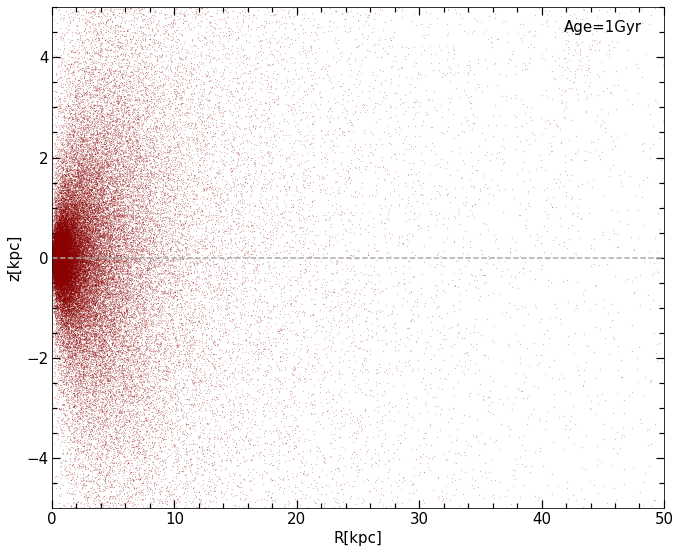

In [53]:
import matplotlib.pyplot as plt
# mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)

# ax.plot(Rstr[mask],zn_str[mask], '.k',markersize=0.05,alpha =0.7)
ax.plot(rr1,z1,   '.', markersize=0.2, alpha = 1, color='darkred')
# ax.plot(rr2,z2,   '.', markersize=0.2, alpha = 1, 1olor='r')
# ax.plot(rr3,z3,   '.', markersize=0.2, alpha = 1, color='darkorange')
# ax.plot(rr4,z4,   '.', markersize=0.2, alpha = 1, color='orange')
# ax.plot(rr5,z5,   '.', markersize=0.2, alpha = 1, color='gold')
# ax.plot(rr6,z6,   '.', markersize=0.2, alpha = 1, color='yellowgreen')
# ax.plot(rr7,z7,   '.', markersize=0.2, alpha = 1, color='lime')
# ax.plot(rr8,z8,   '.', markersize=0.2, alpha = 1, color='g')
# ax.plot(rr9,z9,   '.', markersize=0.2, alpha = 1, color='springgreen')
# ax.plot(rr10,z10, '.', markersize=0.2, alpha = 1, color='c')
# ax.plot(rr11,z11, '.', markersize=0.2, alpha = 1, color='b')
# ax.plot(rr12,z12, '.', markersize=0.2, alpha = 1, color='blueviolet')
# ax.plot(rr13,z13, '.', markersize=0.2, alpha = 1, color='m')
# ax.plot(med_R,z4a,ls='--',color='k')
# ax.plot(med_R,z8a,ls=':',color='k')
# ax.plot(med_R,z10a,ls='-',color='k')
ax.axhline(y=0,ls='--',color='darkgray')
ax.text(45,4.5,'Age=1Gyr',fontsize=15,ha='center')
# for i in range(len(med_R)):
#     ax.axvline(x=med_R[i],ls='--',color='gray')
ax.set_ylim(-5,5)
ax.set_xlim(0,50)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.set_xlabel('R[kpc]',fontsize=15)
ax.set_ylabel('z[kpc]',fontsize=15)
plt.show()
fig.savefig('../_imagenes/test_ages2/age_1.png',dpi=75, xxbox_inches='tight')

In [57]:
%%time
import numpy as np
from astropy.cosmology import Planck13  # Planck 2013
a = np.linspace(1e-3,1,30)
z = 1./a -1
aa = Planck13.age(z)
print(aa)


[4.31516682e-04 1.14384341e-01 3.18261049e-01 5.81341617e-01
 8.92095553e-01 1.24354641e+00 1.63064642e+00 2.04931976e+00
 2.49601931e+00 2.96749652e+00 3.46067790e+00 3.97260249e+00
 4.50039692e+00 5.04127471e+00 5.59255032e+00 6.15166115e+00
 6.71619219e+00 7.28389925e+00 7.85272787e+00 8.42082643e+00
 8.98655262e+00 9.54847356e+00 1.01053602e+01 1.06561773e+01
 1.12000695e+01 1.17363461e+01 1.22644640e+01 1.27840104e+01
 1.32946864e+01 1.37962908e+01] Gyr
CPU times: user 21.4 ms, sys: 4 µs, total: 21.4 ms
Wall time: 20.9 ms


In [59]:
%%time
import time_conversion as time
ab = time.conv2(a,h, Om_L, Om_M)
print(ab)

[5.39399901e-04 1.13840455e-01 3.15167548e-01 5.74699802e-01
 8.81147309e-01 1.22767796e+00 1.60935610e+00 2.02220634e+00
 2.46277859e+00 2.92792105e+00 3.41465726e+00 3.92012237e+00
 4.44153611e+00 4.97619942e+00 5.52150598e+00 6.07496188e+00
 6.63420862e+00 7.19704536e+00 7.76144779e+00 8.32558173e+00
 8.88781080e+00 9.44669805e+00 1.00010021e+01 1.05496690e+01
 1.10918199e+01 1.16267377e+01 1.21538505e+01 1.26727167e+01
 1.31830080e+01 1.36844953e+01]
CPU times: user 976 µs, sys: 1 µs, total: 977 µs
Wall time: 905 µs


In [ ]:
print(len(ab[np.isnan(ab)]))

In [61]:
%%time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=67.77 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=Om_M)
z = 1./a -1
ac = cosmo.age(z)
print (ac)

[4.26794839e-04 1.12617660e-01 3.13387456e-01 5.72488641e-01
 8.78571904e-01 1.22478221e+00 1.60617247e+00 2.01876085e+00
 2.45909332e+00 2.92401563e+00 3.41054967e+00 3.91582947e+00
 4.43707391e+00 4.97158325e+00 5.51675054e+00 6.07008123e+00
 6.62921612e+00 7.19195368e+00 7.75626880e+00 8.32032648e+00
 8.88248949e+00 9.44132003e+00 9.99557590e+00 1.05442022e+01
 1.10863195e+01 1.16212098e+01 1.21483006e+01 1.26671495e+01
 1.31774279e+01 1.36789060e+01] Gyr
CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 17.8 ms


In [88]:
x = np.asarray(aa)
y = np.asarray(ab)
z = np.asarray(ac)

In [84]:
x-y

array([-1.07883220e-04,  5.43885908e-04,  3.09350080e-03,  6.64181465e-03,
        1.09482439e-02,  1.58684541e-02,  2.12903194e-02,  2.71134121e-02,
        3.32407220e-02,  3.95754717e-02,  4.60206390e-02,  5.24801108e-02,
        5.88608109e-02,  6.50752896e-02,  7.10443381e-02,  7.66992664e-02,
        8.19835776e-02,  8.68538911e-02,  9.12800802e-02,  9.52446962e-02,
        9.87418197e-02,  1.01775519e-01,  1.04358095e-01,  1.06508285e-01,
        1.08249537e-01,  1.09608460e-01,  1.10613486e-01,  1.11293774e-01,
        1.11678346e-01,  1.11795432e-01])

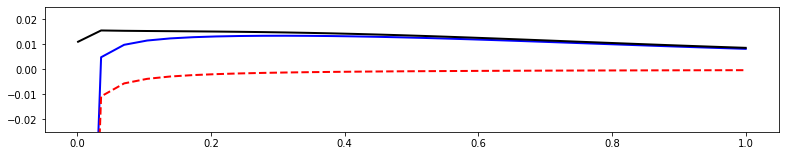

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.97)
r1 =(x-y)/x
r2 =(x-z)/x
r3 =(z-y)/z
ax.plot(a,r1,'-b',lw=2)
ax.plot(a,r2,'-k',lw=2)
ax.plot(a,r3,'--r',lw=2)
ax.set_ylim(-0.025,0.025)
plt.show()